<a href="https://colab.research.google.com/github/MaryaMalyshkina/Grand_line/blob/main/classif_model_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка среды

In [1]:
!pip install torch torchvision Pillow

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image, ImageFile
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import seaborn as sns
from tqdm import tqdm

In [4]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # если используется GPU
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Загрузка данных

In [5]:
# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
# Папка с данными
data_train_dir = '/content/drive/MyDrive/defect_classification/train'

data_val_dir = '/content/drive/MyDrive/defect_classification/val'

In [8]:
# Определение классов
class_names = ['External scuffs', 'Internal scuffs', 'Pack Fracture', 'Scratches curved',
               'Scratches straight', 'Spot jam']
num_classes = len(class_names)

In [9]:
# Функция для проверки изображений
def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return True
    except (IOError, SyntaxError, Exception) as e:
        print(f"Invalid image: {image_path}, error: {e}")
        return False

In [10]:
def load_image_safe(image_path):
    try:
        with Image.open(image_path) as img:
            return img.copy()
    except (IOError, SyntaxError, Exception) as e:
        print(f"Failed to load image: {image_path}, error: {e}")
        # Возвращаем черное изображение как заглушку
        return Image.new('RGB', (224, 224), color='black')

# Настройки датасета и загрузчиков

In [ ]:
# Параметры
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_CLASSES = 6
EPOCHS = 100

In [11]:
# Трансформации для обучения и валидации
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=60),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
# Создание датасета
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Сбор всех изображений и меток
        for class_idx, class_name in enumerate(class_names):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(class_dir, img_name)
                        # Проверяем валидность изображения
                        if is_valid_image(img_path):
                            self.images.append(img_path)
                            self.labels.append(class_idx)
                        else:
                            print(f"Skipping invalid image: {img_path}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
# Загрузка датасета
train_dataset = CustomDataset(data_train_dir, transform=train_transform)
val_dataset = CustomDataset(data_val_dir, transform=val_transform)

print(f"Total images train: {len(train_dataset)}")
print(f"Total images val: {len(val_dataset)}")

Total images train: 605
Total images val: 116


In [14]:
# Создание DataLoader
batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 38, Val batches: 8


# Инициализация модели

In [15]:
def create_model(num_classes=6):

    model = models.resnet18(pretrained=True)

  # Замораживаем все слои, кроме последнего
    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # увеличиваем dropout для регуляризации
        nn.Linear(num_ftrs, num_classes)  # только один слой
    )

    # Размораживаем только классификатор
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

# Устройство (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes)
model = model.to(device)

optimizer = optim.SGD(
    model.fc.parameters(),
    lr=0.0005,
    momentum=0.9,
    weight_decay=5e-4)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [16]:
config = {
    'model': 'ResNet18',
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': 0.0005,
    'optimizer': 'SGD',
    'scheduler': 'ReduceLROnPlateau',
    'seed': 42,
    'device': str(device)
}

import json
with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

# Обучение модели

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    """
    Обучение модели с ранней остановкой и логированием
    """
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    learning_rates = []  # для отслеживания LR

    best_val_loss = float('inf')
    patience, counter = 5, 0  # patience=5 эпох

    # Для сохранения лучшей модели
    best_model_state = None
    best_epoch = 0

    for epoch in range(epochs):
        # === Фаза обучения ===
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Прогресс-бар для обучения
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)

        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)  # умножаем на batch size
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Обновляем прогресс-бар
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*predicted.eq(labels).sum().item()/labels.size(0):.2f}%'
            })

        train_loss = running_loss / total  # делим на общее количество образцов
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # === Фаза валидации ===
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False)

            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*predicted.eq(labels).sum().item()/labels.size(0):.2f}%'
                })

        val_loss /= total_val
        val_acc = 100. * correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Текущий learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Вывод информации
        print(f'\nEpoch [{epoch+1}/{epochs}]:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')

        # === Ранняя остановка ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_epoch = epoch + 1

            # Сохраняем лучшую модель (полную)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'class_names': class_names  # если у вас есть этот список
            }, 'best_model_full.pth')

            # Также сохраняем только веса для инференса
            torch.save(model.state_dict(), 'best_model_weights.pth')
            print(f'  Модель сохранена (лучшая val_loss: {val_loss:.4f})')
        else:
            counter += 1
            if counter >= patience:
                print(f'\n  Ранняя остановка на эпохе {epoch+1}')
                print(f'   Лучшая val_loss: {best_val_loss:.4f} на эпохе {best_epoch}')
                break

        # === Обновление scheduler ===
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

            # Проверяем, изменился ли LR
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != current_lr:
                print(f'  Learning rate изменён: {current_lr:.6f} → {new_lr:.6f}')

        print('-' * 60)

    # Загружаем лучшую модель в конце обучения
    if os.path.exists('best_model_full.pth'):
        checkpoint = torch.load('best_model_full.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f'\n Загружена лучшая модель с эпохи {checkpoint["epoch"]+1}')
        print(f'   Val Loss: {checkpoint["val_loss"]:.4f}, Val Acc: {checkpoint["val_acc"]:.2f}%')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'learning_rates': learning_rates,
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss
    }

In [18]:
set_seed(42)

In [19]:
start = time.perf_counter()

# Запуск обучения
results = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=device
)

end = time.perf_counter()
print(f"Затрачено времени: {end - start:.1f} сек")


Epoch [1/100]:
  Train Loss: 1.9422, Train Acc: 23.47%
  Val Loss: 1.7151, Val Acc: 28.45%
  Learning Rate: 0.000500
  Модель сохранена (лучшая val_loss: 1.7151)
------------------------------------------------------------



Epoch [2/100]:
  Train Loss: 1.8220, Train Acc: 27.27%
  Val Loss: 1.6066, Val Acc: 32.76%
  Learning Rate: 0.000500
  Модель сохранена (лучшая val_loss: 1.6066)
------------------------------------------------------------



Epoch [3/100]:
  Train Loss: 1.7266, Train Acc: 29.75%
  Val Loss: 1.5707, Val Acc: 41.38%
  Learning Rate: 0.000500
  Модель сохранена (лучшая val_loss: 1.5707)
------------------------------------------------------------



Epoch [4/100]:
  Train Loss: 1.6574, Train Acc: 34.38%
  Val Loss: 1.5697, Val Acc: 36.21%
  Learning Rate: 0.000500
  Модель сохранена (лучшая val_loss: 1.5697)
------------------------------------------------------------



Epoch [5/100]:
  Train Loss: 1.6180, Train Acc: 38.84%
  Val Loss: 1.5524, Val Acc: 41.38%
  Learning Rate: 0.000500
  Модель сохранена (лучшая val_loss: 1.5524)
------------------------------------------------------------



Epoch [6/100]:
  Train Loss: 1.6020, Train Acc: 33.22%
  Val Loss: 1.5758, Val Acc: 40.52%
  Learning Rate: 0.000500
------------------------------------------------------------



Epoch [7/100]:
  Train Loss: 1.5096, Train Acc: 40.17%
  Val Loss: 1.4852, Val Acc: 44.83%
  Learning Rate: 0.000500
  Модель сохранена (лучшая val_loss: 1.4852)
------------------------------------------------------------



Epoch [8/100]:
  Train Loss: 1.5265, Train Acc: 37.69%
  Val Loss: 1.4777, Val Acc: 43.97%
  Learning Rate: 0.000500
  Модель сохранена (лучшая val_loss: 1.4777)
------------------------------------------------------------



Epoch [9/100]:
  Train Loss: 1.5312, Train Acc: 39.50%
  Val Loss: 1.4682, Val Acc: 48.28%
  Learning Rate: 0.000500
  Модель сохранена (лучшая val_loss: 1.4682)
------------------------------------------------------------



Epoch [10/100]:
  Train Loss: 1.5411, Train Acc: 37.85%
  Val Loss: 1.4545, Val Acc: 44.83%
  Learning Rate: 0.000500
  Модель сохранена (лучшая val_loss: 1.4545)
------------------------------------------------------------



Epoch [11/100]:
  Train Loss: 1.5092, Train Acc: 38.18%
  Val Loss: 1.5022, Val Acc: 46.55%
  Learning Rate: 0.000500
------------------------------------------------------------



Epoch [12/100]:
  Train Loss: 1.4257, Train Acc: 44.79%
  Val Loss: 1.4808, Val Acc: 43.97%
  Learning Rate: 0.000500
------------------------------------------------------------



Epoch [13/100]:
  Train Loss: 1.4599, Train Acc: 42.31%
  Val Loss: 1.4797, Val Acc: 44.83%
  Learning Rate: 0.000500
------------------------------------------------------------



Epoch [14/100]:
  Train Loss: 1.4844, Train Acc: 42.81%
  Val Loss: 1.4584, Val Acc: 46.55%
  Learning Rate: 0.000500
  Learning rate изменён: 0.000500 → 0.000250
------------------------------------------------------------



Epoch [15/100]:
  Train Loss: 1.4978, Train Acc: 43.31%
  Val Loss: 1.4322, Val Acc: 45.69%
  Learning Rate: 0.000250
  Модель сохранена (лучшая val_loss: 1.4322)
------------------------------------------------------------



Epoch [16/100]:
  Train Loss: 1.4333, Train Acc: 44.30%
  Val Loss: 1.4221, Val Acc: 47.41%
  Learning Rate: 0.000250
  Модель сохранена (лучшая val_loss: 1.4221)
------------------------------------------------------------



Epoch [17/100]:
  Train Loss: 1.4306, Train Acc: 43.97%
  Val Loss: 1.4434, Val Acc: 45.69%
  Learning Rate: 0.000250
------------------------------------------------------------



Epoch [18/100]:
  Train Loss: 1.3935, Train Acc: 45.45%
  Val Loss: 1.4499, Val Acc: 44.83%
  Learning Rate: 0.000250
------------------------------------------------------------



Epoch [19/100]:
  Train Loss: 1.4162, Train Acc: 42.48%
  Val Loss: 1.4446, Val Acc: 49.14%
  Learning Rate: 0.000250
------------------------------------------------------------



Epoch [20/100]:
  Train Loss: 1.3993, Train Acc: 45.95%
  Val Loss: 1.4408, Val Acc: 49.14%
  Learning Rate: 0.000250
  Learning rate изменён: 0.000250 → 0.000125
------------------------------------------------------------



Epoch [21/100]:
  Train Loss: 1.4049, Train Acc: 44.79%
  Val Loss: 1.4459, Val Acc: 48.28%
  Learning Rate: 0.000125

  Ранняя остановка на эпохе 21
   Лучшая val_loss: 1.4221 на эпохе 16

 Загружена лучшая модель с эпохи 16
   Val Loss: 1.4221, Val Acc: 47.41%
Затрачено времени: 2689.3 сек


Best epoch: {results['best_epoch']}

Best val loss: {results['best_val_loss']:.4f}

Final train acc: {results['train_accs'][-1]:.2f}%

Final val acc: {results['val_accs'][-1]:.2f}%


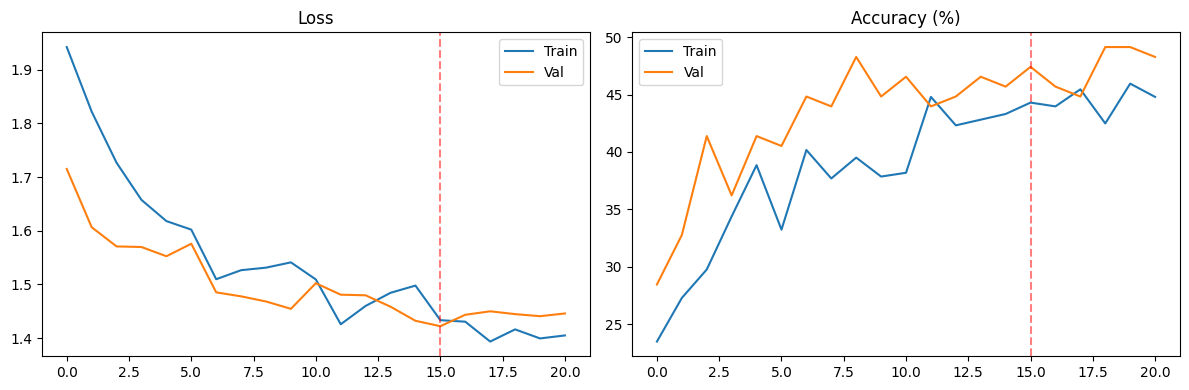

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(results['train_losses'], label='Train')
axes[0].plot(results['val_losses'], label='Val')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].axvline(x=results['best_epoch']-1, color='r', linestyle='--', alpha=0.5)

# Accuracy
axes[1].plot(results['train_accs'], label='Train')
axes[1].plot(results['val_accs'], label='Val')
axes[1].set_title('Accuracy (%)')
axes[1].legend()
axes[1].axvline(x=results['best_epoch']-1, color='r', linestyle='--', alpha=0.5)

print("Best epoch: {results['best_epoch']}\n")
print("Best val loss: {results['best_val_loss']:.4f}\n")
print("Final train acc: {results['train_accs'][-1]:.2f}%\n")
print("Final val acc: {results['val_accs'][-1]:.2f}%")

plt.tight_layout()
plt.show()

In [21]:
# Функция для предсказания на новых изображениях
def predict_image(image_path, model, class_names, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item()

    return class_names[predicted_class], confidence

# Пример использования функции предсказания
predicted_class, confidence = predict_image('/content/drive/MyDrive/defect_classification/test/Pack Fracture/635089d5-WhatsApp_Image_2025-09-18_at_14.47.27_4.jpeg', model, class_names, device)
print(f"Predicted: {predicted_class}, Confidence: {confidence:.2f}")

Predicted: Pack Fracture, Confidence: 0.41


In [22]:
def get_predictions(model, dataloader, device):
    """
    Получение предсказаний модели
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Получение предсказаний"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

# Получите предсказания для валидационного набора
y_pred, y_true, y_probs = get_predictions(model, val_loader, device)

print(f"y_pred shape: {y_pred.shape}")
print(f"y_true shape: {y_true.shape}")
print(f"y_probs shape: {y_probs.shape}")

Получение предсказаний: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it]

y_pred shape: (116,)
y_true shape: (116,)
y_probs shape: (116, 6)


In [23]:
# Classification Report
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,  # список имен классов
    output_dict=True  # Чтобы преобразовать в DataFrame
)

# Преобразуем в DataFrame
report_df = pd.DataFrame(report).transpose()

print("=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(report_df.to_string())

# Сохраняем в файл
report_df.to_csv('classification_report.csv', index=True)
print("\n Classification Report сохранен в 'classification_report.csv'")

# Красивое отображение важных метрик
print("\n" + "=" * 80)
print("СВОДНЫЕ МЕТРИКИ ПО КЛАССАМ")
print("=" * 80)

for i, class_name in enumerate(class_names):
    class_data = report[class_name]
    print(f"\n{class_name}:")
    print(f"  Precision: {class_data['precision']:.3f}")
    print(f"  Recall:    {class_data['recall']:.3f}")
    print(f"  F1-Score:  {class_data['f1-score']:.3f}")
    print(f"  Support:   {class_data['support']}")

print(f"\n{'='*80}")
print(f"Overall Accuracy: {report['accuracy']:.3f}")
print(f"Macro Avg F1: {report['macro avg']['f1-score']:.3f}")
print(f"Weighted Avg F1: {report['weighted avg']['f1-score']:.3f}")

CLASSIFICATION REPORT
                    precision    recall  f1-score     support
External scuffs      0.500000  0.111111  0.181818   18.000000
Internal scuffs      0.285714  0.200000  0.235294   10.000000
Pack Fracture        0.600000  0.300000  0.400000   10.000000
Scratches curved     0.566667  0.566667  0.566667   30.000000
Scratches straight   0.000000  0.000000  0.000000    8.000000
Spot jam             0.442857  0.775000  0.563636   40.000000
accuracy             0.474138  0.474138  0.474138    0.474138
macro avg            0.399206  0.325463  0.324569  116.000000
weighted avg         0.453202  0.474138  0.423889  116.000000

 Classification Report сохранен в 'classification_report.csv'

СВОДНЫЕ МЕТРИКИ ПО КЛАССАМ

External scuffs:
  Precision: 0.500
  Recall:    0.111
  F1-Score:  0.182
  Support:   18.0

Internal scuffs:
  Precision: 0.286
  Recall:    0.200
  F1-Score:  0.235
  Support:   10.0

Pack Fracture:
  Precision: 0.600
  Recall:    0.300
  F1-Score:  0.400
  Suppor

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix shape: (6, 6)
Всего примеров: 116


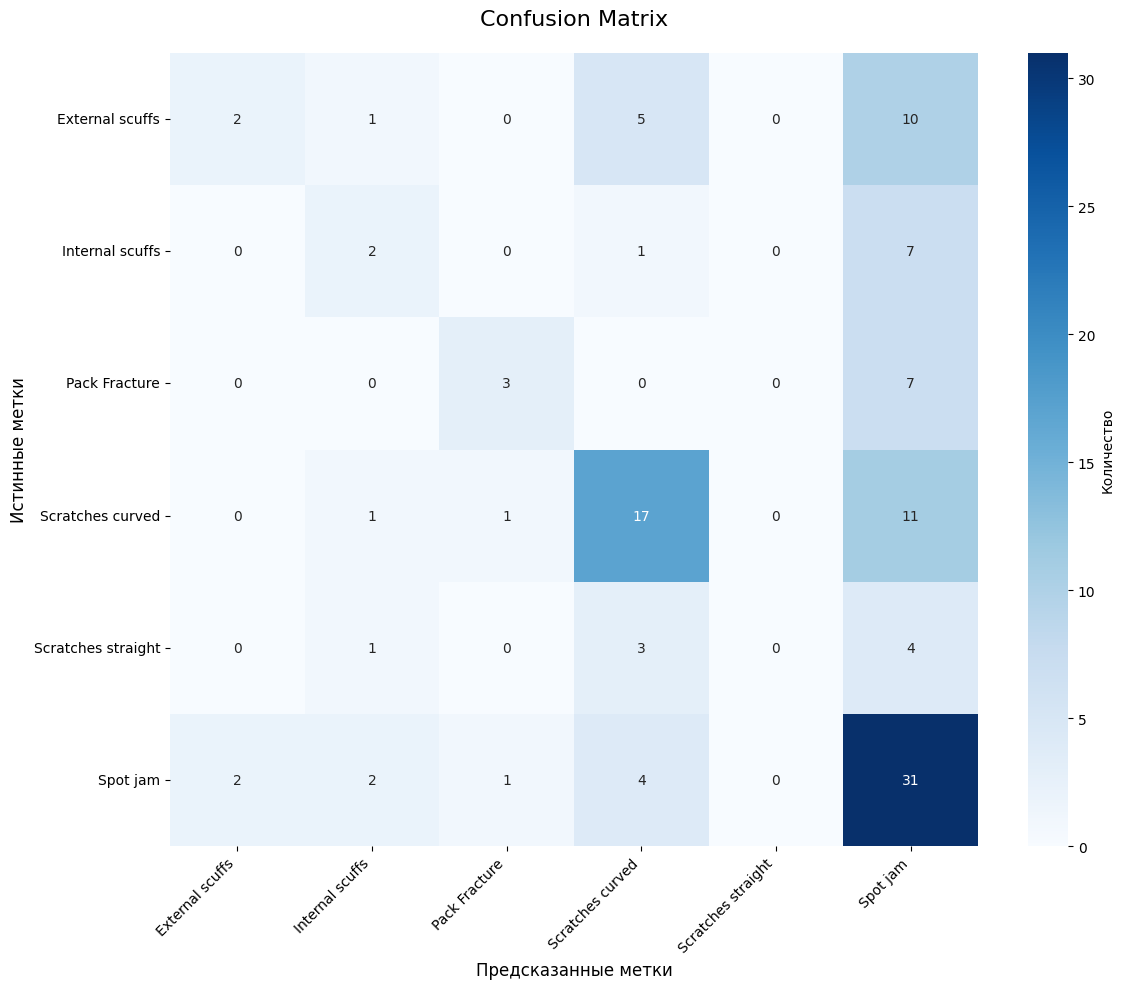

Confusion Matrix сохранена в 'confusion_matrix.png'


In [24]:
# Вычисляем confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(f"Confusion Matrix shape: {cm.shape}")
print(f"Всего примеров: {cm.sum()}")

# Создаем визуализацию
plt.figure(figsize=(12, 10))

# Heatmap confusion matrix
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Количество'})

plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.ylabel('Истинные метки', fontsize=12)
plt.xlabel('Предсказанные метки', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Сохраняем
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion Matrix сохранена в 'confusion_matrix.png'")


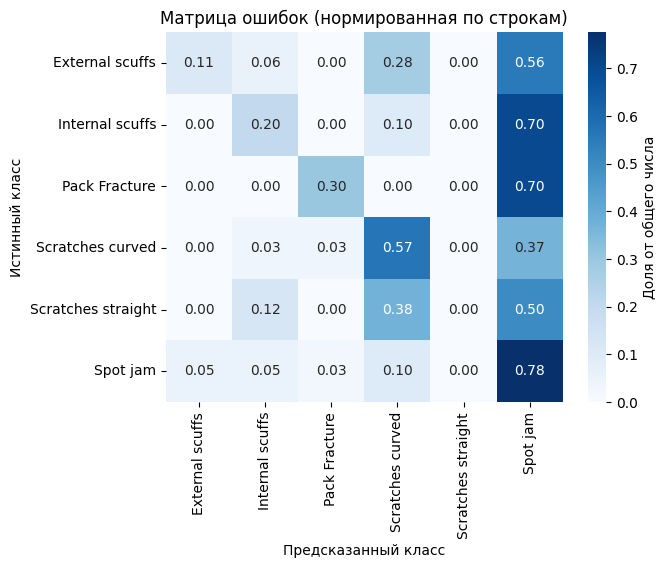

<Figure size 640x480 with 0 Axes>

Confusion normalized Matrix сохранена в 'normalized_matrix.png'


In [34]:
# Нормируем по строкам (True labels)
# показывает, как распределяются предсказания для каждого истинного класса
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Доля от общего числа'})
plt.title('Матрица ошибок (нормированная по строкам)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.show()

# Сохраняем
plt.savefig('normalized_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion normalized Matrix сохранена в 'normalized_matrix.png'")

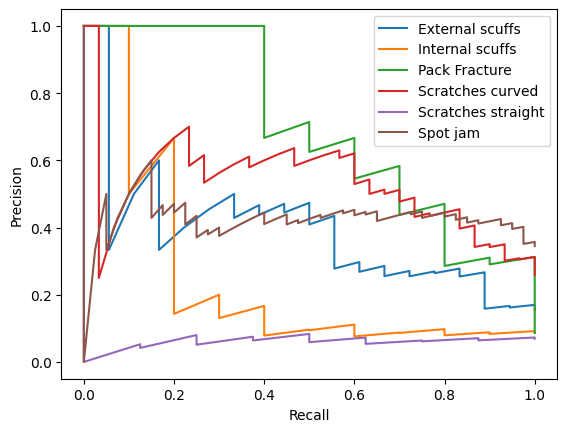

<Figure size 640x480 with 0 Axes>

Precision - Recall сохранена в 'precision_recall.png'


In [31]:
for i, cls in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true==i, y_probs[:, i])
    plt.plot(recall, precision, label=cls)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Сохраняем
plt.savefig('precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

print("Precision - Recall сохранена в 'precision_recall.png'")
